## 1. Loading libraries

In [2]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings = warnings

In [3]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

In [4]:
# load libraries and modules
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

## 2. Train/ Test Split

In [5]:
path_t0_df = ROOT_DIR / 'data' / "t0_v3.csv"  
t0_df = pd.read_csv(path_t0_df)
t0_df = t0_df.drop(columns=["SUBJECT_ID", "HADM_ID"])
t0_df

,IS_SEPSIS,Blood_Bicarbonate_50882,"Blood_Calcium, Total_50893",Blood_Creatinine_50912,Blood_Glucose_50931,Blood_Hematocrit_51221,Blood_Hemoglobin_51222,Blood_INR(PT)_51237,Blood_Lactate_50813,Blood_Lymphocytes_51244,...,Blood_Platelet Count_51265,Blood_Red Blood Cells_51279,Blood_Urea Nitrogen_51006,Blood_White Blood Cells_51301,Blood_pCO2_50818,Blood_pH_50820,Blood_pO2_50821,Urine_RBC_51493,AGE,GENDER_NUM
0,0,25.0,8.2,3.2,91.0,30.2,10.0,1.3,-999.0,8.0,...,282.0,3.44,53.0,12.7,-999.0,-999.0,-999.0,-999.0,76,0
1,0,24.0,8.9,0.5,140.0,34.2,11.5,-999.0,-999.0,6.9,...,207.0,3.80,9.0,9.7,-999.0,-999.0,-999.0,-999.0,47,1
2,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,65,1
3,0,30.0,-999.0,1.2,129.0,45.2,15.4,1.1,-999.0,41.6,...,258.0,5.46,16.0,7.5,-999.0,-999.0,-999.0,-999.0,41,0
4,0,25.0,-999.0,0.7,121.0,36.9,12.5,1.1,-999.0,7.6,...,229.0,4.31,12.0,8.5,-999.0,-999.0,-999.0,-999.0,50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47880,1,-999.0,-999.0,-999.0,-999.0,36.4,12.4,-999.0,-999.0,8.1,...,349.0,4.20,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,53,0
47881,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,47,0
47882,0,22.0,7.1,1.2,206.0,12.9,4.7,1.1,-999.0,9.1,...,188.0,1.35,56.0,21.4,-999.0,-999.0,-999.0,-999.0,65,1
47883,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,88,1


In [6]:
X_t0_train, X_t0_test, y_t0_train, y_t0_test = train_test_split(
    t0_df.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
    t0_df['IS_SEPSIS'],
    test_size=0.2,  # this means 20% test set
    stratify=t0_df['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)

# If you want to get the train and test set as dataframes:
train_t0_df = pd.concat([X_t0_train, y_t0_train], axis=1)
test_t0_df = pd.concat([X_t0_test, y_t0_test], axis=1)

train_t0_df

,Blood_Bicarbonate_50882,"Blood_Calcium, Total_50893",Blood_Creatinine_50912,Blood_Glucose_50931,Blood_Hematocrit_51221,Blood_Hemoglobin_51222,Blood_INR(PT)_51237,Blood_Lactate_50813,Blood_Lymphocytes_51244,Blood_Neutrophils_51256,...,Blood_Red Blood Cells_51279,Blood_Urea Nitrogen_51006,Blood_White Blood Cells_51301,Blood_pCO2_50818,Blood_pH_50820,Blood_pO2_50821,Urine_RBC_51493,AGE,GENDER_NUM,IS_SEPSIS
35555,22.0,-999.0,0.8,114.0,42.5,14.1,1.0,-999.0,12.1,84.1,...,5.06,21.0,7.7,-999.0,-999.0,-999.0,-999.0,83,1,0
41480,36.0,10.7,1.6,112.0,37.8,12.0,4.7,-999.0,5.8,89.3,...,4.46,43.0,10.8,-999.0,-999.0,-999.0,-999.0,85,1,0
32579,24.0,-999.0,5.2,57.0,32.3,10.0,-999.0,-999.0,6.5,90.0,...,3.51,52.0,15.0,-999.0,-999.0,-999.0,-999.0,60,1,1
29617,-999.0,-999.0,1.2,-999.0,29.0,10.2,1.3,-999.0,-999.0,-999.0,...,3.02,15.0,28.8,-999.0,-999.0,-999.0,-999.0,33,0,0
11940,14.0,8.5,5.5,95.0,34.8,11.9,-999.0,-999.0,1.0,68.0,...,3.67,83.0,17.3,-999.0,-999.0,-999.0,-999.0,72,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37588,24.0,9.4,1.0,153.0,43.9,14.4,2.3,-999.0,44.0,8.0,...,5.49,16.0,2.2,-999.0,-999.0,-999.0,-999.0,73,0,0
29590,24.0,8.3,0.5,102.0,32.1,10.3,1.3,-999.0,13.2,82.2,...,3.94,26.0,9.2,-999.0,-999.0,-999.0,-999.0,22,1,0
1749,8.0,12.1,4.1,119.0,50.3,16.3,1.2,-999.0,3.6,92.8,...,5.79,71.0,18.9,-999.0,-999.0,-999.0,-999.0,51,0,0
16650,23.0,-999.0,0.6,117.0,24.6,8.6,0.9,-999.0,14.2,81.7,...,2.76,15.0,10.1,-999.0,-999.0,-999.0,-999.0,81,1,0


In [7]:
# Counting the number of instance in each class in the training set
label_counts = train_t0_df["IS_SEPSIS"].value_counts()
label_proportions = label_counts / len(train_t0_df)*100

label_info = pd.DataFrame({'Count': label_counts, 'Proportion': label_proportions.map("{:.2f}%".format)})
print(label_info)

           Count Proportion
IS_SEPSIS                  
0          34367     89.71%
1           3941     10.29%


In [8]:
# Counting the number of instance in each class in the test set
label_test_counts = test_t0_df["IS_SEPSIS"].value_counts()
label_test_proportions = label_test_counts / len(test_t0_df)*100

label_test_info = pd.DataFrame({'Count': label_test_counts, 'Proportion': label_test_proportions.map("{:.2f}%".format)})
print(label_test_info)

           Count Proportion
IS_SEPSIS                  
0           8592     89.71%
1            985     10.29%


## 3. Features Scaling

In [9]:
t0_df.describe()

,IS_SEPSIS,Blood_Bicarbonate_50882,"Blood_Calcium, Total_50893",Blood_Creatinine_50912,Blood_Glucose_50931,Blood_Hematocrit_51221,Blood_Hemoglobin_51222,Blood_INR(PT)_51237,Blood_Lactate_50813,Blood_Lymphocytes_51244,...,Blood_Platelet Count_51265,Blood_Red Blood Cells_51279,Blood_Urea Nitrogen_51006,Blood_White Blood Cells_51301,Blood_pCO2_50818,Blood_pH_50820,Blood_pO2_50821,Urine_RBC_51493,AGE,GENDER_NUM
count,47885.000000,47885.000000,47885.000000,47885.000000,47885.000000,47885.000000,47885.000000,47885.000000,47885.000000,47885.000000,...,47885.000000,47885.000000,47885.000000,47885.000000,47885.000000,47885.000000,47885.000000,47885.000000,47885.000000,47885.000000
mean,0.102871,-442.748155,-753.519140,-388.575881,-379.648261,-364.404901,-381.671768,-538.923030,-948.724834,-503.976237,...,-230.785215,-387.304899,-372.407894,-380.786102,-935.102955,-934.038692,-921.626960,-972.257711,62.067641,0.437172
std,0.303794,509.735536,432.616945,488.050121,582.149115,503.867242,492.965306,498.678243,218.678922,507.162828,...,621.022643,489.236430,501.834119,492.780975,250.220777,247.297496,305.442967,162.053642,16.048411,0.496042
min,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,18.000000,0.000000
25%,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,52.000000,0.000000
50%,0.000000,17.000000,-999.000000,0.700000,86.000000,29.700000,9.800000,-999.000000,-999.000000,-999.000000,...,159.000000,3.250000,13.000000,6.400000,-999.000000,-999.000000,-999.000000,-999.000000,63.000000,0.000000
75%,0.000000,25.000000,-999.000000,1.200000,131.000000,37.500000,12.700000,1.200000,-999.000000,12.200000,...,263.000000,4.190000,25.000000,11.400000,-999.000000,-999.000000,-999.000000,-999.000000,75.000000,1.000000
max,1.000000,56.000000,23.300000,43.000000,2340.000000,75.000000,22.300000,88.800000,20.400000,100.000000,...,2315.000000,8.970000,274.000000,846.700000,194.000000,7.720000,667.000000,675.000000,89.000000,1.000000


In [10]:
# Feature scaling - Standardisation
scaler = StandardScaler()

X_t0_train = scaler.fit_transform(X_t0_train)
X_t0_test = scaler.transform(X_t0_test)

In [11]:
X_t0_train

array([[ 0.91017244, -0.56762322,  0.79583558, ..., -0.16537418,
         1.30385383,  1.1349013 ],
       [ 0.93764133,  1.76593885,  0.79747568, ..., -0.16537418,
         1.42849193,  1.1349013 ],
       [ 0.91409657, -0.56762322,  0.80485611, ..., -0.16537418,
        -0.1294843 ,  1.1349013 ],
       ...,
       [ 0.88270355,  1.76917446,  0.80260098, ..., -0.16537418,
        -0.69035575, -0.88113389],
       [ 0.9121345 , -0.56762322,  0.79542556, ..., -0.16537418,
         1.17921573,  1.1349013 ],
       [-1.09309418, -0.56762322, -1.25387483, ..., -0.16537418,
        -0.31644145, -0.88113389]])

## 4. Model Fitting

### 4.1 Logistic Regression

#### 4.1.1 Model Training

In [12]:
# Calculate class weights
class_weights = {0: 1 / (label_proportions[0] / 100), 1: 1 / (label_proportions[1] / 100)}

# Round the class weights to the desired precision (optional)
class_weights = {key: round(weight, 4) for key, weight in class_weights.items()}

print("Class Weights:", class_weights)

Class Weights: {0: 1.1147, 1: 9.7204}


In [13]:
# Fitting a Logistic Regression Classifier
t0_lr = LogisticRegression(random_state=901, class_weight=class_weights)
t0_lr.fit(X_t0_train, y_t0_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(class_weight={0: 1.1147, 1: 9.7204}, random_state=901)

#### 4.1.2 Performance Measurement

In [14]:
# Function for performance measures on (i) confusion matrix, (ii) balanced accuracy, (iii) precision, (iv) recall and (v) F1 score
def performance_measure(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Computating the confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)    

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    
    x_labels = ["Predicted\nNon-Sepsis", "Predicted\nSepsis"]
    y_labels = ["Actual Non-Sepsis", "Actual Sepsis"]
    sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=x_labels, yticklabels=y_labels, ax=axes[0])
    sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=x_labels, yticklabels=y_labels, ax=axes[1])
    
    axes[0].set_title("CM in training set", fontsize = 10)
    axes[1].set_title("CM in test set", fontsize = 10)
    axes[0].tick_params(labelsize=9)
    axes[1].tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

    # Computing balanced accuracy
    balanced_acc_train = balanced_accuracy_score(y_train, y_pred_train)
    balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)
    print("\nBalanced Accuracy: Training set {:.4f}".format(balanced_acc_train), "; Test set {:.4f}".format(balanced_acc_test))    

    # Computing precision and recall
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    print("Precision: Training set {:.4f}".format(precision_train), "; Test set {:.4f}".format(precision_test))
    print("Recall: Training set {:.4f}".format(recall_train), "; Test set {:.4f}".format(recall_test))

    # Computing F1 score
    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    print("F1 score: Training set {:.4f}".format(f1_train), "; Test set {:.4f}".format(f1_test))

In [15]:
# Plotting ROC curve to determine the threshold
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=11) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=11)
    plt.grid(True)

In [16]:
# Looking at some predictions from the testing set
some_data = X_t0_test[:5]
some_labels = y_t0_test[:5]
print("Predictions:", t0_lr.predict(some_data))
print("Labels:", some_labels.values.flatten().tolist())

Predictions: [0 0 1 0 1]
Labels: [0, 0, 0, 0, 0]


In [17]:
t0_lr_predictions = t0_lr.predict(X_t0_test)
t0_lr_predicted_probabilities = t0_lr.predict_proba(X_t0_test)

Performance measures on Logistic Regression Classifier:



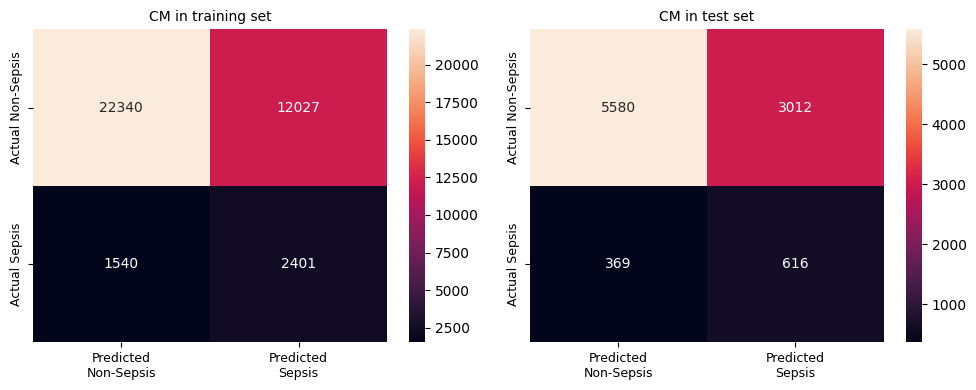


Balanced Accuracy: Training set 0.6296 ; Test set 0.6374
Precision: Training set 0.1664 ; Test set 0.1698
Recall: Training set 0.6092 ; Test set 0.6254
F1 score: Training set 0.2614 ; Test set 0.2671


In [18]:
print("Performance measures on Logistic Regression Classifier:\n")
performance_measure(t0_lr, X_t0_train, X_t0_test, y_t0_train, y_t0_test)

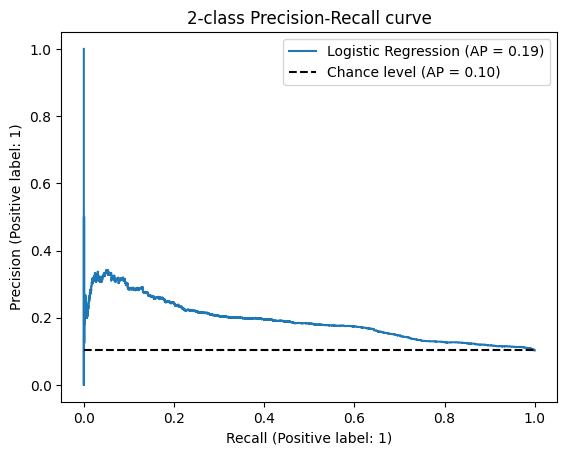

In [19]:
display = PrecisionRecallDisplay.from_estimator(
    t0_lr, X_t0_test, y_t0_test, name="Logistic Regression", plot_chance_level=True
)
display.ax_.legend(loc='upper right')
_ = display.ax_.set_title("2-class Precision-Recall curve")

AUC = 0.6666


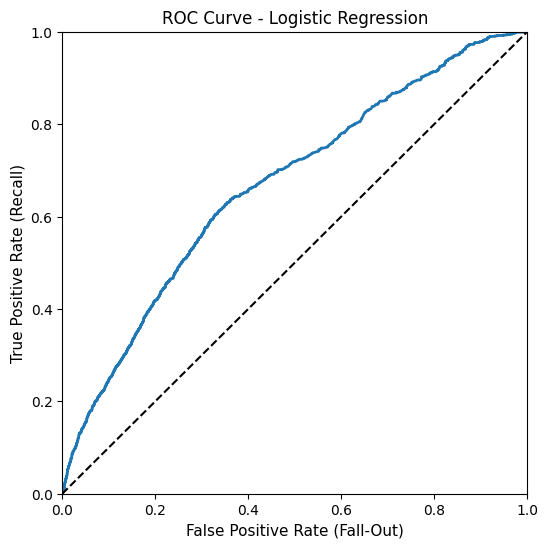

In [20]:
# Plotting ROC curve
fpr_lr_test, tpr_lr_test, thresholds_roc_lr_test = roc_curve(y_t0_test, t0_lr_predicted_probabilities[:, 1], pos_label=1)
auc_t0_lr = auc(fpr_lr_test, tpr_lr_test)
print("AUC = {:.4f}".format(auc_t0_lr))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_lr_test, tpr_lr_test)
plt.title("ROC Curve - Logistic Regression")
plt.grid(False)
plt.show()

#### 4.1.3 Feature Selection

In [21]:
feature_coeff = t0_lr.coef_[0]
feature_names = train_t0_df.columns[:-1]
feature_importance = list(zip(feature_names, feature_coeff))
sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

print('Feature importance from Logistic Regression:\n')

# Determine the maximum length of feature names for alignment
max_length = max([len(feature) for feature, _ in sorted_features])

for feature, coef in sorted_features:
    # Use ljust() to align feature names
    print('{} Coefficient: {:.4f}'.format(feature.ljust(max_length), coef))


Feature importance from Logistic Regression:

Blood_Neutrophils_51256       Coefficient: 4.5796
Blood_Lymphocytes_51244       Coefficient: -4.0138
Blood_White Blood Cells_51301 Coefficient: 1.8823
Blood_pO2_50821               Coefficient: -1.5517
Blood_pCO2_50818              Coefficient: 1.3215
Blood_Hematocrit_51221        Coefficient: -1.2956
Blood_INR(PT)_51237           Coefficient: -1.0508
Blood_PT_51274                Coefficient: 0.8848
Blood_Urea Nitrogen_51006     Coefficient: 0.8454
Blood_Creatinine_50912        Coefficient: -0.7967
Blood_Platelet Count_51265    Coefficient: -0.4800
Blood_Hemoglobin_51222        Coefficient: -0.3159
Blood_Lactate_50813           Coefficient: 0.2848
Blood_Calcium, Total_50893    Coefficient: 0.2434
Blood_Glucose_50931           Coefficient: -0.1761
AGE                           Coefficient: 0.1564
Blood_pH_50820                Coefficient: -0.1522
Blood_Bicarbonate_50882       Coefficient: 0.1317
Blood_Red Blood Cells_51279   Coefficient: -0

#### 4.1.4 Individual features - ITEM_ID 50912 (for reference)

In [22]:
feature_columns = t0_df.columns.drop("IS_SEPSIS").tolist()
target_column = ["IS_SEPSIS"]

# Convert numpy array back to DataFrame
X_t0_train_df = pd.DataFrame(X_t0_train, columns=feature_columns)
y_t0_train_df = pd.DataFrame(y_t0_train, columns=target_column)

X_t0_test_df = pd.DataFrame(X_t0_test, columns=feature_columns)
y_t0_test_df = pd.DataFrame(y_t0_test, columns=target_column)

# Extract specific feature for Logistic Regression
column_50912 = X_t0_train_df.filter(like='_50912').columns[0]
X_t0_train_50912 = X_t0_train_df[column_50912].values.reshape(-1, 1)
y_t0_train_50912 = y_t0_train_df["IS_SEPSIS"]

X_t0_test_50912 = X_t0_test_df[column_50912].values.reshape(-1, 1)
y_t0_test_50912 = y_t0_test_df["IS_SEPSIS"]

t0_lr.fit(X_t0_train_50912, y_t0_train_50912)

LogisticRegression(class_weight={0: 1.1147, 1: 9.7204}, random_state=901)

In [23]:
# Estimated probabilities and decision boundary of "ITEM_ID 50912"
min_50912 = np.min(X_t0_train_df[column_50912].values)
max_50912 = np.max(X_t0_train_df[column_50912].values)

X_new_50912 = np.linspace(min_50912, max_50912, 1000).reshape(-1,1)
y_train_50912_proba = t0_lr.predict_proba(X_new_50912)

threshold_50912 = 0.5
decision_boundary_50912 = X_new_50912[y_train_50912_proba[:, 0] >= threshold_50912][0]
print("Decision boundary of ITEM_ID 50912 is {:.4f}".format(decision_boundary_50912[0]))

Decision boundary of ITEM_ID 50912 is -1.2539


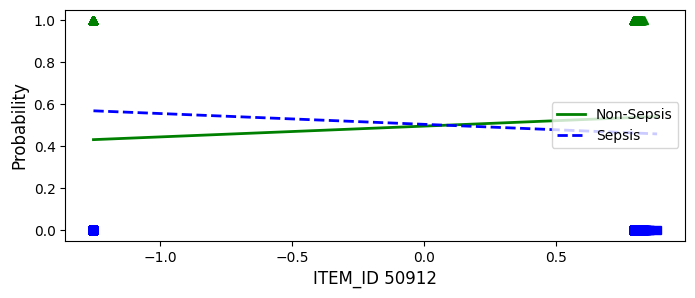

In [24]:
# Plotting the estimated probabilities and decision boundary
plt.figure(figsize=(8, 3))
plt.plot(X_t0_train_50912[y_t0_train_50912 == 0], y_t0_train_50912[y_t0_train_50912 == 0], "bs")
plt.plot(X_t0_train_50912[y_t0_train_50912 == 1], y_t0_train_50912[y_t0_train_50912 == 1], "g^")
#plt.plot([decision_boundary_50912, decision_boundary_50912], [-3, 3], "k:", linewidth=2)
plt.plot(X_new_50912, y_train_50912_proba[:, 1], "g-", linewidth = 2, label = "Non-Sepsis")
plt.plot(X_new_50912, y_train_50912_proba[:, 0], "b--", linewidth = 2, label = "Sepsis")
plt.xlabel("ITEM_ID 50912", fontsize = 12)
plt.ylabel("Probability", fontsize = 12)
plt.legend(loc = "center right", fontsize = 10)

plt.show()

### 4.2 Random Forest

#### 4.2.1 Model Training

In [25]:
# Define the RMSE scoring metric as a callable
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return sqrt(mse)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [26]:
# t0_rf = RandomForestClassifier(random_state=901,class_weight=class_weights)

# params = {
#   "max_depth": list(range(3,8)),
#   "min_samples_split": [2, 25, 50, 100, 125, 250, 500, 1000],
#   "min_samples_leaf": [2, 25, 50, 100, 125, 250, 500, 1000]
# }

# t0_rf_grid_search = GridSearchCV(estimator=t0_rf, param_grid=params, scoring='balanced_accuracy', cv=3)
# t0_rf_grid_search.fit(X_t0_train, y_t0_train)

# best_params_rf = t0_rf_grid_search.best_params_
# best_balanced_accuracy_rf = t0_rf_grid_search.best_score_

# print("Best Hyperparameters: ", best_params_rf)
# print("Best Balanced Accuracy: ", best_balanced_accuracy_rf)

Best Hyperparameters:  {'max_depth': 7, 'min_samples_leaf': 25, 'min_samples_split': 250}
Best Balanced Accuracy:  0.6851931012564533


In [29]:
t0_rf_best = RandomForestClassifier(random_state=901,class_weight=class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250)
t0_rf_best.fit(X_t0_train, y_t0_train)

TypeError: __init__() got an unexpected keyword argument 'min_sampels_leaf'

In [ ]:
# Predict the test set using the best random forest regressor
y_pred_rf = t0_rf_best.predict(X_t0_test)
y_pred_rf = np.round(y_pred_rf) # Round the predictions to the nearest integer
t0_rf_predicted_probabilities = t0_rf_best.predict_proba(X_t0_test)

#### 4.2.2 Performance Measurement

In [ ]:
# Compute the RMSE of the predictions on the test set
rmse_rf = np.sqrt(mean_squared_error(y_t0_test, y_pred_rf))
print("Random Forest Classifier Test set RMSE: {:.4f}".format(rmse_rf))

Random Forest Classifier Test set RMSE: 0.3598


Performance measures on Random Forest Classifier:



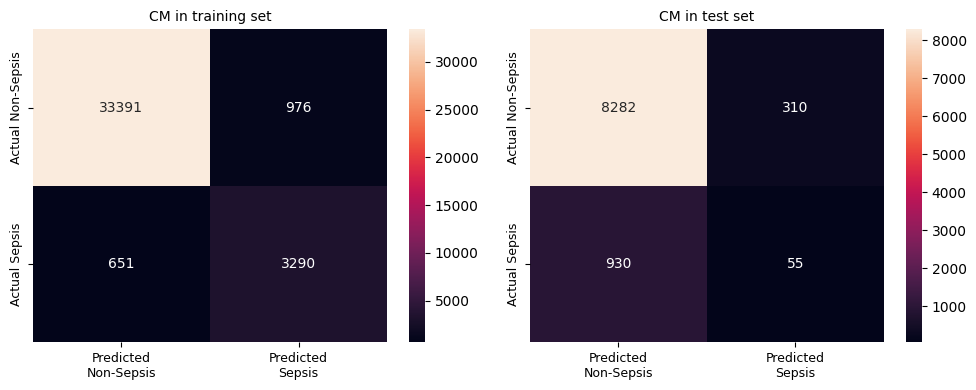


Balanced Accuracy: Training set 0.9032 ; Test set 0.5099
Precision: Training set 0.7712 ; Test set 0.1507
Recall: Training set 0.8348 ; Test set 0.0558
F1 score: Training set 0.8018 ; Test set 0.0815


In [ ]:
print("Performance measures on Random Forest Classifier:\n")
performance_measure(t0_rf_best, X_t0_train, X_t0_test, y_t0_train, y_t0_test)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    t0_rf_best, X_t0_test, y_t0_test, name="Random Forest", plot_chance_level=True
)
display.ax_.legend(loc='upper right')
_ = display.ax_.set_title("2-class Precision-Recall curve")

AUC = 0.6542


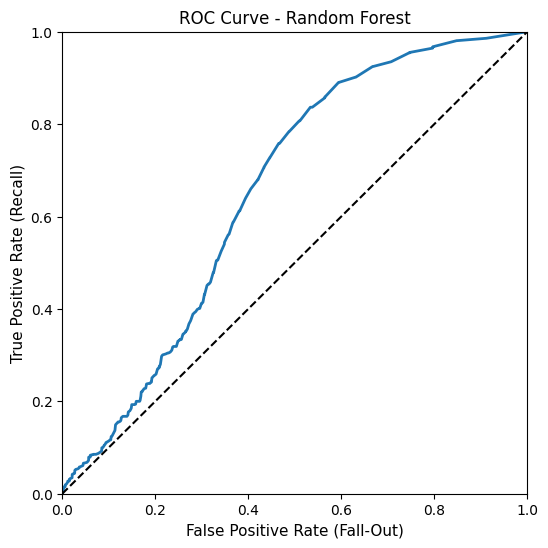

In [ ]:
# Plotting ROC curve
fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(y_t0_test, t0_rf_predicted_probabilities[:, 1], pos_label=1)
auc_t0_rf = auc(fpr_rf_test, tpr_rf_test)
print("AUC = {:.4f}".format(auc_t0_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_rf_test, tpr_rf_test)
plt.title("ROC Curve - Random Forest")
plt.grid(False)
plt.show()

#### 4.2.3 Feature Selections

In [29]:
# Create a SelectFromModel object to remove features with importance values below 0.05
selector = SelectFromModel(t0_rf_best, threshold=0.05, prefit=True)

# Transform the training and test data to retain only the selected features
X_t0_train_reduced = selector.transform(X_t0_train)
X_t0_test_reduced = selector.transform(X_t0_test)

# Print the names of the retained features
feature_names = train_t0_df.columns[:-1][selector.get_support()]

importance_scores = t0_rf_best.feature_importances_[selector.get_support()]

# Combine feature names and their importance scores
feature_importance = list(zip(feature_names, importance_scores))

# Sort the features by importance score in descending order
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)

print('Selected features:')

# Determine the maximum length of feature names for alignment
max_length = max([len(feature) for feature, _ in sorted_features])
for feature, score in sorted_features:
    # Use ljust() to align feature names
    print('{} Importance Score: {:.4f}'.format(feature.ljust(max_length), score))

# Print the total feature importance value that is retained after dimension reduction
total_importance = np.sum(t0_rf_best.feature_importances_[selector.get_support()])
print('\nTotal feature importance: {:.4f}'.format(total_importance))

Selected features:
AGE                           Importance Score: 0.0973
Blood_White Blood Cells_51301 Importance Score: 0.0809
Blood_Lymphocytes_51244       Importance Score: 0.0801
Blood_Creatinine_50912        Importance Score: 0.0670
Blood_Neutrophils_51256       Importance Score: 0.0661
Blood_Urea Nitrogen_51006     Importance Score: 0.0635
Blood_Platelet Count_51265    Importance Score: 0.0611
Blood_Hematocrit_51221        Importance Score: 0.0526
Blood_Red Blood Cells_51279   Importance Score: 0.0510
Blood_Glucose_50931           Importance Score: 0.0507

Total feature importance: 0.6704


### 4.3 Gradient Boosting

#### 4.3.1 Model Training

In [28]:
# Tuning hyperparameters

# t0_gb = GradientBoostingClassifier(random_state=901)

# params_gb = {
#   'n_estimators': [50, 100, 150, 200], 
#   'learning_rate': [0.01, 0.1, 0.2, 0.5], 
#   'loss': ['log_loss', 'exponential'], 
#   'criterion': ['friedman_mse', 'squared_error'],
#   'max_features': ['sqrt', 'log2'],
#   'max_depth': list(range(3,8))
# }

# t0_gb_grid_search = GridSearchCV(estimator=t0_gb, param_grid=params_gb, scoring='balanced_accuracy', cv=3)
# t0_gb_grid_search.fit(X_t0_train, y_t0_train)

# best_params_gb = t0_gb_grid_search.best_params_
# best_balanced_accuracy_gb = t0_gb_grid_search.best_score_

# print("Best Hyperparameters: ", best_params_gb)
# print("Best Balanced Accuracy: ", best_balanced_accuracy_gb)

Best Hyperparameters:  {'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}
Best Balanced Accuracy:  0.5600920457121906


In [35]:
# params_gb_v2 = {
#   'n_estimators': [100], 
#   'learning_rate': [0.1], 
#   'max_depth': [3]
# }

# t0_gb_grid_search_v2 = GridSearchCV(estimator=t0_gb, param_grid=params_gb_v2, scoring='balanced_accuracy', cv=3)
# t0_gb_grid_search_v2.fit(X_t0_train, y_t0_train)

# best_params_gb_v2 = t0_gb_grid_search_v2.best_params_
# best_balanced_accuracy_gb_v2 = t0_gb_grid_search_v2.best_score_

# print("Best Hyperparameters: ", best_params_gb_v2)
# print("Best Balanced Accuracy: ", best_balanced_accuracy_gb_v2)

Best Hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Balanced Accuracy:  0.5265521101883315


In [30]:
# Initialize the Gradient Boosting Classifier
t0_gb_v1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=901)

# Train the classifier on the training data
t0_gb_v1.fit(X_t0_train, y_t0_train, sample_weight=[class_weights[label] for label in y_t0_train])

GradientBoostingClassifier(random_state=901)

In [32]:
# Predict on the test set
y_t0_pred = t0_gb_v1.predict(X_t0_test)
t0_gb_predicted_probabilities = t0_gb_v1.predict_proba(X_t0_test)

#### 4.3.2 Performance Measurement

Performance measures on Gradient Boosting Classifier:



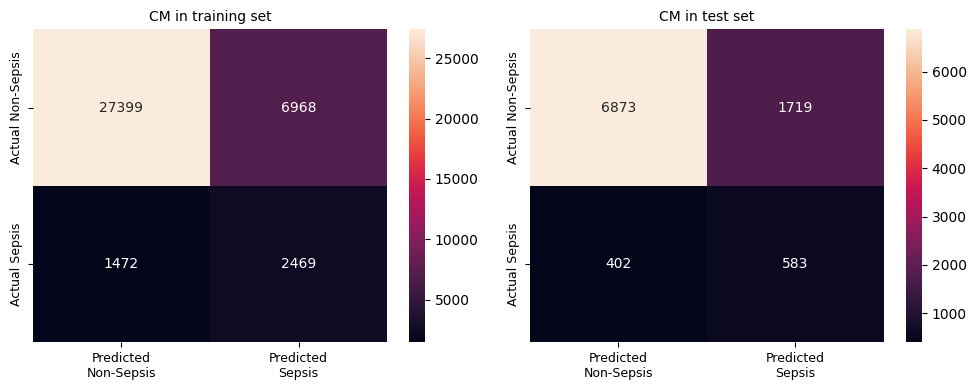


Balanced Accuracy: Training set 0.7119 ; Test set 0.6959
Precision: Training set 0.2616 ; Test set 0.2533
Recall: Training set 0.6265 ; Test set 0.5919
F1 score: Training set 0.3691 ; Test set 0.3547


In [33]:
print("Performance measures on Gradient Boosting Classifier:\n")
performance_measure(t0_gb_v1, X_t0_train, X_t0_test, y_t0_train, y_t0_test)

AUC = 0.7646


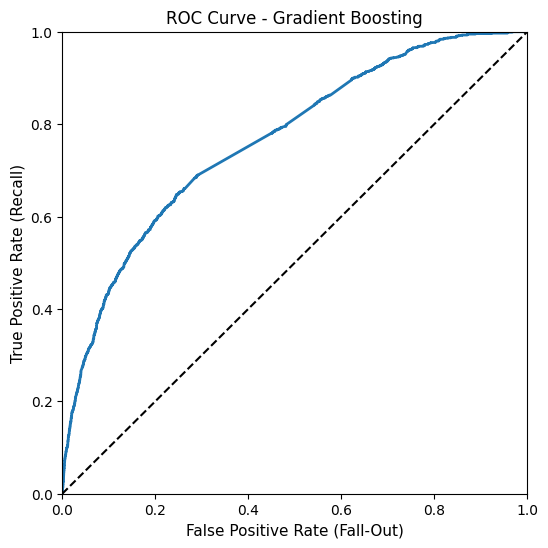

In [33]:
# Plotting ROC curve
fpr_gb_test, tpr_gb_test, thresholds_roc_gb_test = roc_curve(y_t0_test, t0_gb_predicted_probabilities[:, 1], pos_label=1)
auc_t0_gb = auc(fpr_gb_test, tpr_gb_test)
print("AUC = {:.4f}".format(auc_t0_gb))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_gb_test, tpr_gb_test)
plt.title("ROC Curve - Gradient Boosting")
plt.grid(False)
plt.show()

#### 4.3.3 Feature selection

In [34]:
# Create a SelectFromModel object to remove features with importance values below 0.02
selector_gb = SelectFromModel(t0_gb, threshold=0.02, prefit=True)

# Transform the training and test data to retain only the selected features
X_t0_train_gb_reduced = selector_gb.transform(X_t0_train)
X_t0_test_gb_reduced = selector_gb.transform(X_t0_test)

# Print the names of the retained features
feature_names = train_t0_df.columns[:-1][selector_gb.get_support()]
importance_scores_gb = t0_gb.feature_importances_[selector_gb.get_support()]

# Combine feature names and their importance scores
feature_importance_gb = list(zip(feature_names, importance_scores_gb))

# Sort the features by importance score in descending order
sorted_features_gb = sorted(feature_importance_gb, key=lambda x: x[1], reverse=True)

print('Selected features (Gradient Boosting):\n')
# Determine the maximum length of feature names for alignment
max_length = max([len(feature) for feature, _ in sorted_features_gb])
for feature, score in sorted_features_gb:
    # Use ljust() to align feature names
    print('{} Importance Score: {:.4f}'.format(feature.ljust(max_length), score))

# Print the total feature importance value that is retained after dimension reduction
total_importance_gb = np.sum(t0_gb.feature_importances_[selector_gb.get_support()])
print('\nTotal feature importance (Gradient Boosting): {:.4f}'.format(total_importance_gb))

Selected features (Gradient Boosting):

Blood_Creatinine_50912        Importance Score: 0.1804
Blood_White Blood Cells_51301 Importance Score: 0.1424
Blood_Lymphocytes_51244       Importance Score: 0.1227
Blood_Neutrophils_51256       Importance Score: 0.1048
Blood_Platelet Count_51265    Importance Score: 0.0576
Blood_Lactate_50813           Importance Score: 0.0489
Blood_Calcium, Total_50893    Importance Score: 0.0373
Blood_Hemoglobin_51222        Importance Score: 0.0373
Blood_Urea Nitrogen_51006     Importance Score: 0.0351
Blood_pH_50820                Importance Score: 0.0312
Blood_pO2_50821               Importance Score: 0.0293
Blood_PT_51274                Importance Score: 0.0291
Blood_INR(PT)_51237           Importance Score: 0.0275
AGE                           Importance Score: 0.0230
Blood_Red Blood Cells_51279   Importance Score: 0.0227

Total feature importance (Gradient Boosting): 0.9291
